In [1]:
from io import StringIO
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import glob
from scipy.integrate import cumtrapz
from scipy.fft import fft
import numpy as np
from obspy import Trace
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from sklearn.ensemble import IsolationForest
from scipy import signal
from sklearn.linear_model import LinearRegression

lunar_cat_directory = './space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
lunar_cat_file = lunar_cat_directory + 'apollo12_catalog_GradeA_final.csv'
lunar_cat = pd.read_csv(lunar_cat_file)

# load data directories
lunar_training_data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
mars_training_data_directory = './space_apps_2024_seismic_detection/data/mars/training/data'

num_files = len(lunar_cat)


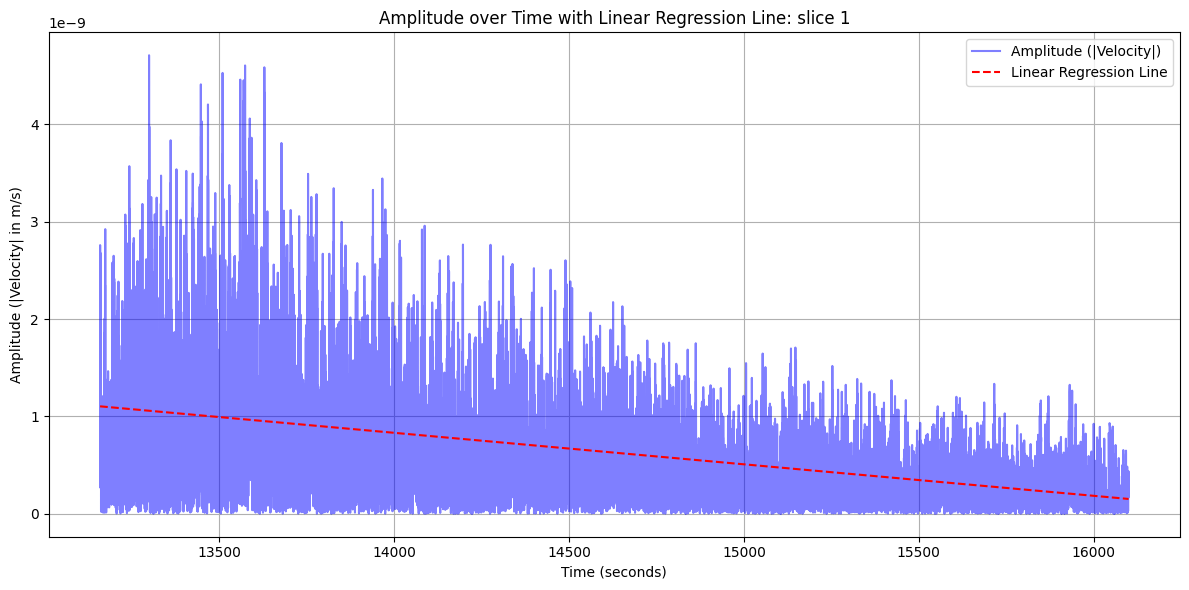

Slope: -3.233525774394476e-13
R² (correlation coefficient): 0.2111443354601028


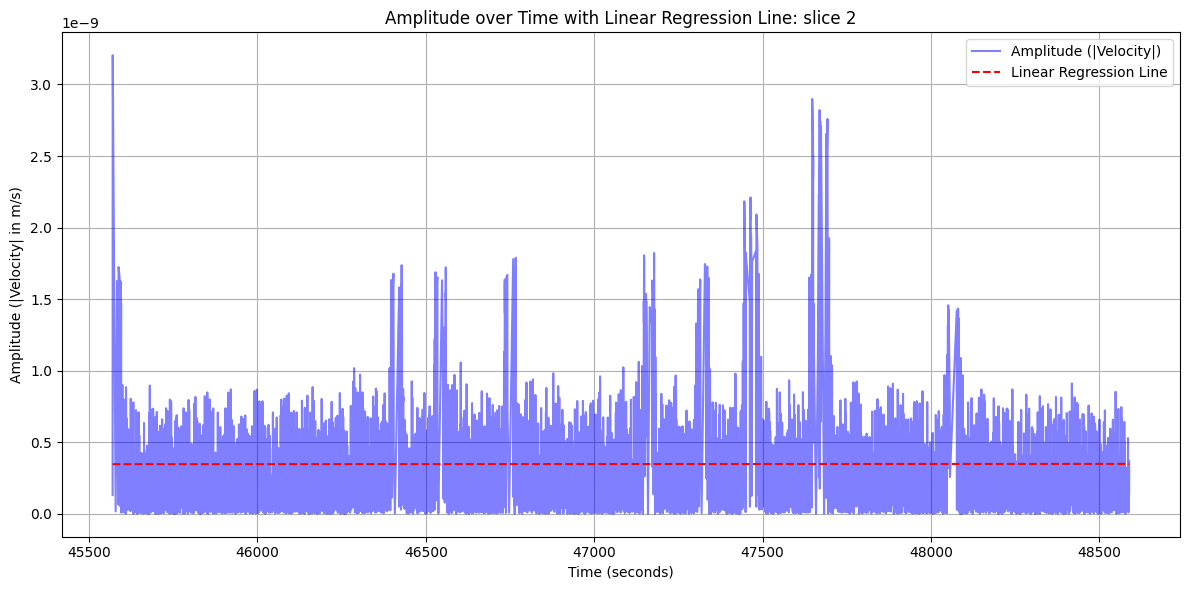

Slope: 6.953807051693263e-16
R² (correlation coefficient): 2.3671357054499964e-06


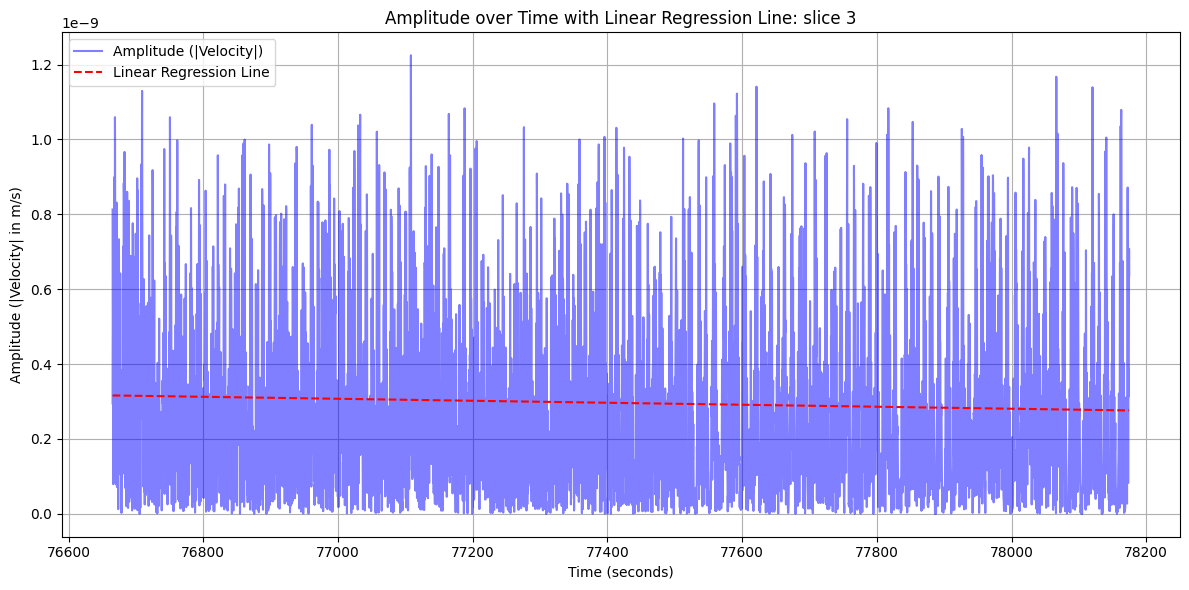

Slope: -2.6550655711286722e-14
R² (correlation coefficient): 0.0026828215237147957


In [17]:
def sta_lta(df, sta, lta, thr_on, thr_off):
    velocity = df["velocity(m/s)"]
    rel_time = np.array(df["time_rel(sec)"])
    samp_rate = 1/(rel_time[1] - rel_time[0])

    cft = classic_sta_lta(velocity, int(sta * samp_rate), int(lta * samp_rate))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(rel_time,cft)
    ax.set_xlim([min(rel_time),max(rel_time)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')


    times = []
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    for i in np.arange(0, len(on_off)):
        trigger = on_off[i]
        abs_time = df["time_abs(%Y-%m-%dT%H:%M:%S.%f)"][trigger[0]]
        times.append((abs_time, rel_time[trigger[0]]))
        ax.axvline(x = rel_time[trigger[0]], color='red', label='Trig. On')
        ax.axvline(x = rel_time[trigger[1]], color='purple', label='Trig. Off')

    ax.plot(rel_time, velocity)
    ax.set_xlim([min(rel_time),max(rel_time)])
    ax.legend()   

    trig_indeces = []
    for i in np.arange(0, len(on_off)):
        trigger = on_off[i]
        trig_indeces.append((trigger[0], trigger[1]))

    return trig_indeces


sta_len, lta_len = 1500, 10000
on, off = 2, 1
num_files = len(lunar_cat)


# lunar_training_file = lunar_training_data_directory + lunar_cat['filename'][1] + '.csv'
# l_training_df = pd.read_csv('sliced4.csv')
    
# sta_lta(l_training_df, sta_len, lta_len, on, off)



def plot_velocity_over_time(input_csv):
    """
    Plots velocity over relative time from a CSV file containing velocity data.
    """
    # Load data from CSV
    df = pd.read_csv(input_csv)

    # Extract relative time and velocity
    time_rel = df['time_rel(sec)'].values
    velocity = df['velocity(m/s)'].values

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(time_rel, velocity, label='Velocity Over Time', color='#00008B')  # Darker blue color
    plt.xlabel('Relative Time (seconds)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity Over Time (Relative)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def extract_rows(input_csv, output_csv, start_row, end_row):
    df = pd.read_csv(input_csv, skiprows=lambda x: x not in range(0, end_row) or (x > 0 and x < start_row))
    df.to_csv(output_csv, index=False)
    
test_file = "./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv"
extract_rows(test_file, 'sliced.csv', 87178, 106664)
extract_rows(test_file, 'sliced2.csv', 301902, 321902)
extract_rows(test_file, 'sliced3.csv', 507909,517909)
extract_rows(test_file, 'sliced4.csv', 398604,467389)


def regression_analysis(df, slice_number):
    """
    Analyzes amplitude (absolute value of velocity) over time data by performing linear regression,
    returning the correlation (R²), and plotting the amplitude data with the regression line.

    Returns:
    - float: The correlation coefficient (R² value) representing the linear fit.
    """
    
    time = df['time_rel(sec)'].values.reshape(-1, 1)  # Reshape to be used as input in sklearn
    velocity = df['velocity(m/s)'].values

    # Calculate amplitude as the absolute value of velocity
    amplitude = np.abs(velocity)

    # Fit linear regression to the amplitude data
    model = LinearRegression()
    model.fit(time, amplitude)

    # Get the slope and correlation coefficient (R² value)
    slope = model.coef_[0]
    r_squared = model.score(time, amplitude)

    # Generate predicted values for the regression line on amplitude
    amplitude_pred = model.predict(time)

    # Plotting the amplitude data and the regression line
    plt.figure(figsize=(12, 6))
    plt.plot(time, amplitude, label='Amplitude (|Velocity|)', color='blue', alpha=0.5)
    plt.plot(time, amplitude_pred, label='Linear Regression Line', color='red', linestyle='--')

    # Adding labels and title to the plot
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (|Velocity| in m/s)')
    plt.title(f'Amplitude over Time with Linear Regression Line: slice {slice_number}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print slope and R² value for verification
    print(f"Slope: {slope}")
    print(f"R² (correlation coefficient): {r_squared}")

    # Return the correlation coefficient (R² value)
    return r_squared

df1 = pd.read_csv('sliced.csv')
df2 = pd.read_csv('sliced2.csv')
df3 = pd.read_csv('sliced3.csv')

# Run the regression analysis on each DataFrame slice
regression_analysis(df1, 1)
regression_analysis(df2, 2)
regression_analysis(df3, 3)


# plot_velocity_over_time('sliced.csv')
# plot_velocity_over_time('sliced2.csv')
# plot_velocity_over_time('sliced3.csv')
# plot_velocity_over_time('sliced4.csv')

def is_seismic(df):
    """
    Analyzes the possible slices of seismic data by finding trigger events, slicing them, and running linear regression to determine if they represent seismic activity.
    
    Returns:
    - list: A list of indices of true positives
    """
    time_rel = df['time_rel(sec)'].values
    trig_inds = sta_lta(df, sta_len, lta_len, on, off)
        
    false_positives = []
    true_positives = []
    
    for i, (start_idx, end_idx) in enumerate(trig_inds):
        start_idx = max(0, start_idx)
        end_idx = min(len(df), end_idx)
        
        df_slice = df.iloc[start_idx:end_idx]
        print(f"Analyzing slice {i + 1} (from index {start_idx} to {end_idx})")
        r_squared_value = regression_analysis(df_slice, i)
        print(f"Slice {i + 1} - Correlation Coefficient (R²): {r_squared_value}\n")
        
        
        if r_squared_value > 0.15:
            true_positives.append(time_rel[start_idx])
        else:
            false_positives.append(time_rel[start_idx])
            
    print(f"false_positives: {false_positives}")
    print(f"true_positives: {true_positives}")
    
    return true_positives


Analyzing slice 1 (from index 87176 to 105981)


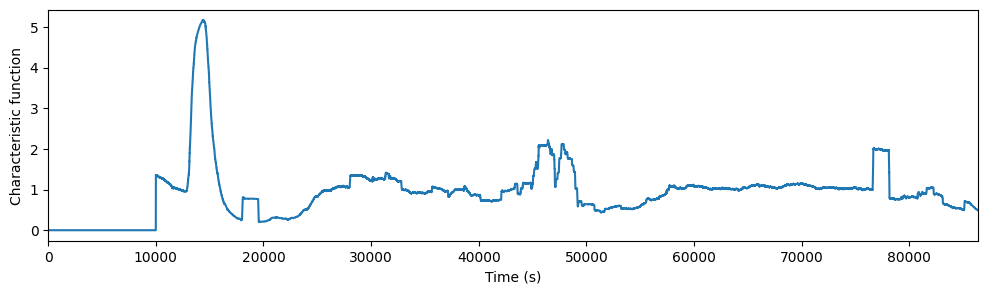

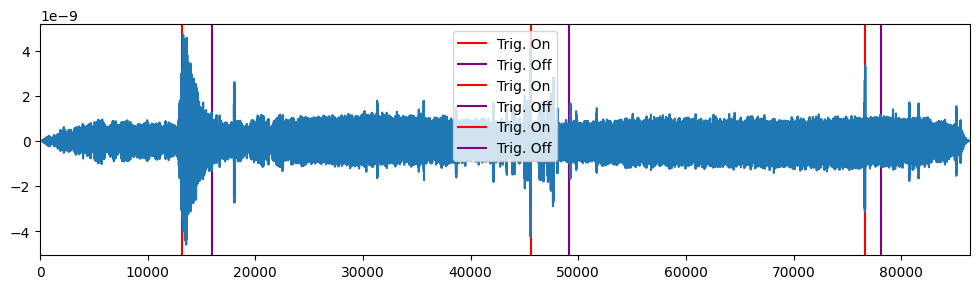

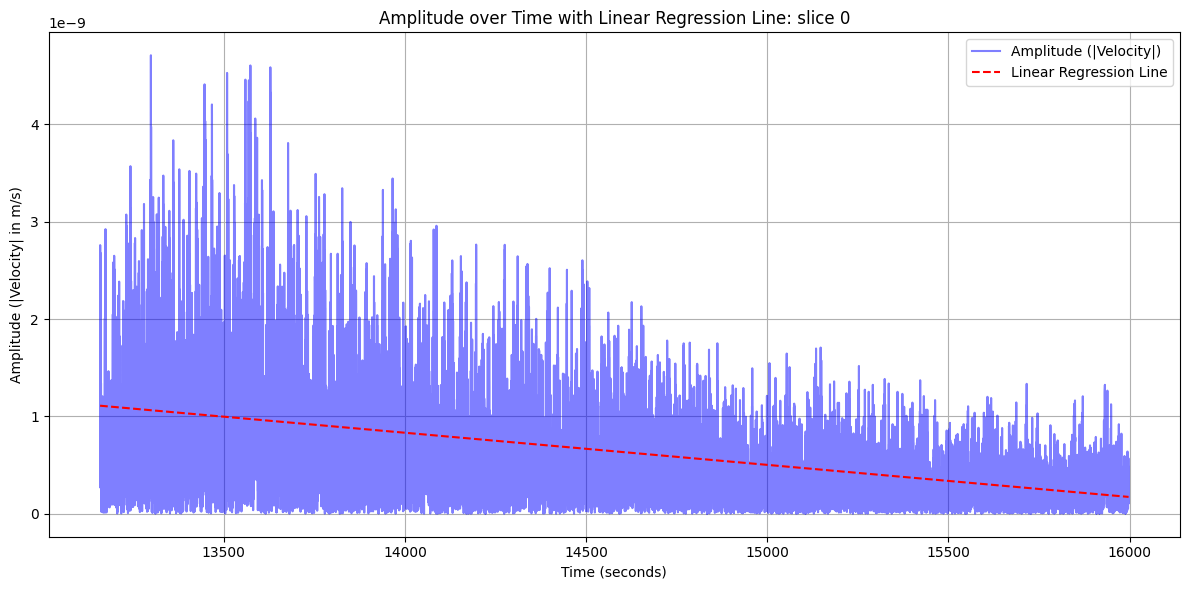

Slope: -3.298525936267757e-13
R² (correlation coefficient): 0.20124525472536048
Slice 1 - Correlation Coefficient (R²): 0.20124525472536048

Analyzing slice 2 (from index 301900 to 325600)


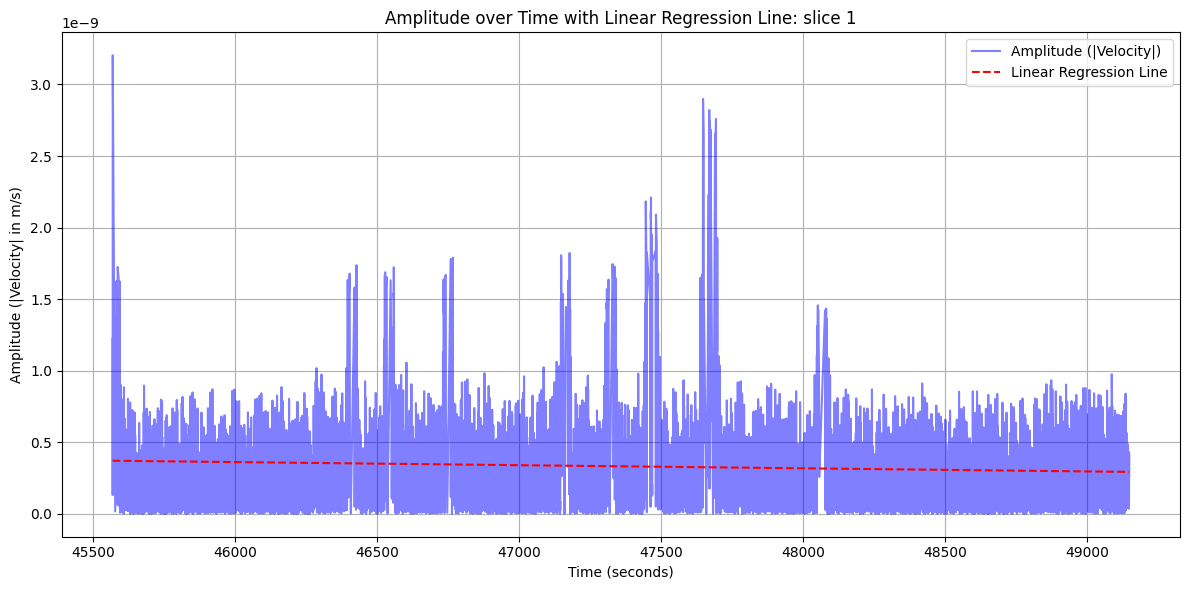

Slope: -2.1785462785639107e-14
R² (correlation coefficient): 0.003666299357171554
Slice 2 - Correlation Coefficient (R²): 0.003666299357171554

Analyzing slice 3 (from index 507907 to 517765)


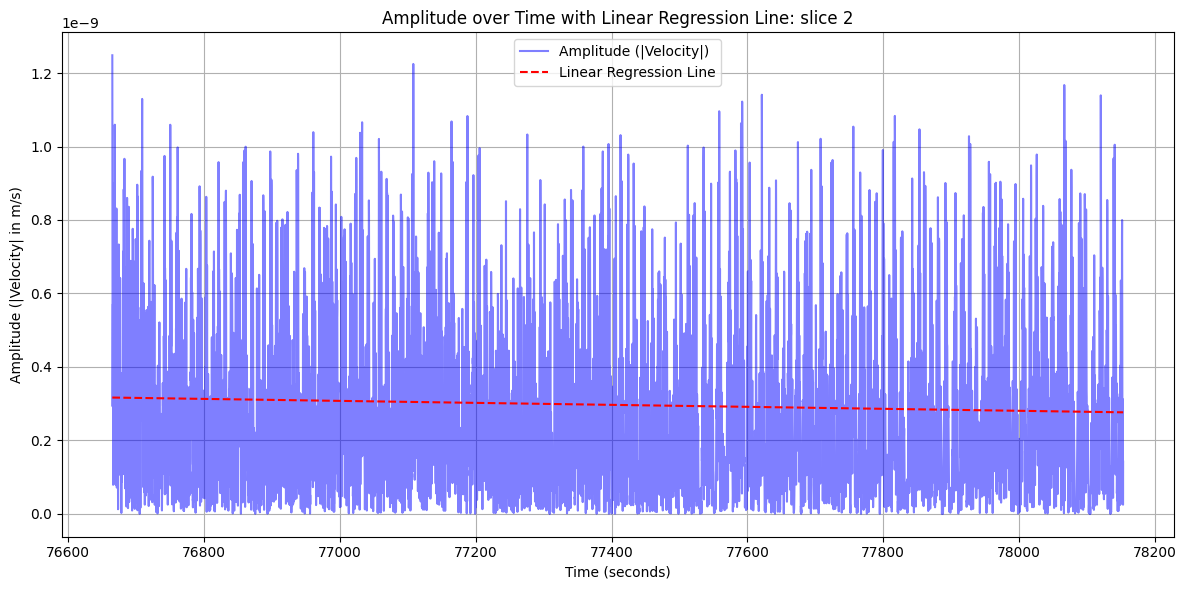

Slope: -2.7018694123866456e-14
R² (correlation coefficient): 0.002707945216604779
Slice 3 - Correlation Coefficient (R²): 0.002707945216604779

false_positives: [45569.81132075472, 76665.2075471698]
true_positives: [13158.641509433965]


[13158.641509433965]

In [11]:
df = pd.read_csv('./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv')
is_seismic(df)

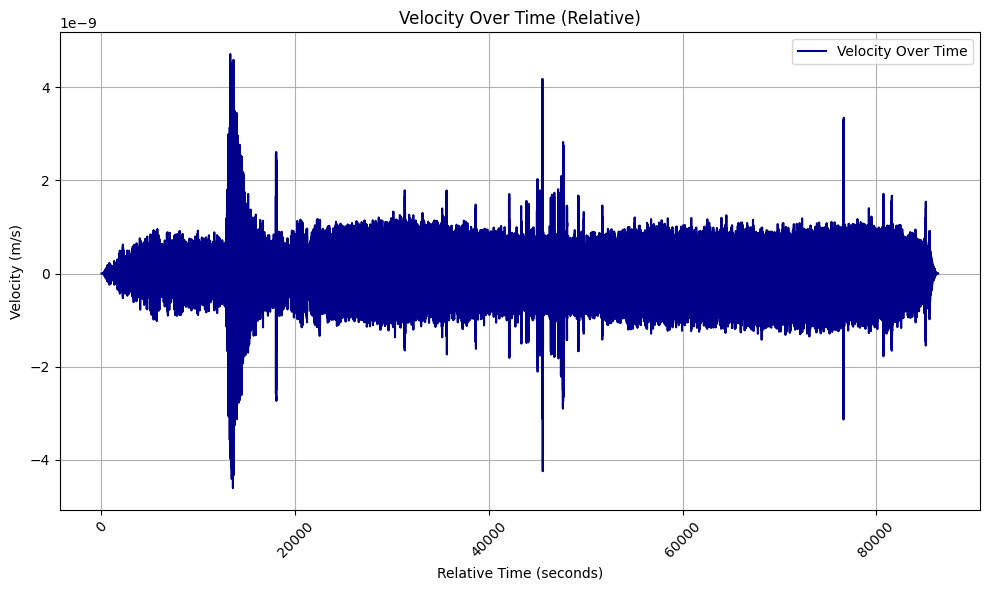

In [18]:
plot_velocity_over_time('./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv')

In [ ]:
lunar_training_file = lunar_training_data_directory + lunar_cat['filename'][0] + '.csv'
l_training_df = pd.read_csv(lunar_training_file)
is_seismic(l_training_df)